In [1]:
## This data prep script 
# Make 0 = unfav/unprivi and 1 fav/priv
# Import Data handling/display libraries

import pandas as pd
import numpy as np
import seaborn               as sns
import matplotlib.pyplot     as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import MinMaxScaler, StandardScaler
from sklearn.base            import TransformerMixin
from sklearn.pipeline        import Pipeline, FeatureUnion
from typing                  import List, Union, Dict
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the Adult training dataset
Adult_df = pd.read_csv('./input/adult.csv')

In [3]:
# Clean the data
# Replace '?' in relevant columns with the most frequent value in the column 
attrib, counts = np.unique(Adult_df['Employment'], return_counts = True)
most_freq_attrib = attrib[np.argmax(counts, axis=0)]
Adult_df['Employment'].replace(' ?',most_freq_attrib,inplace=True)

attrib, counts = np.unique(Adult_df['Occupation'], return_counts = True)
most_freq_attrib = attrib[np.argmax(counts, axis = 0)]
#Adult_df['Occupation'].replace('?',most_freq_attrib,inplace=True)
Adult_df['Occupation'].replace('?',most_freq_attrib,inplace=True)

attrib, counts = np.unique(Adult_df['NativeCountry'], return_counts = True)
most_freq_attrib = attrib[np.argmax(counts, axis = 0)]
Adult_df['NativeCountry'].replace('?',most_freq_attrib,inplace=True)

In [4]:
Adult_df['Income'].replace('>50K' ,1, inplace=True)
Adult_df['Income'].replace('<=50K',0, inplace=True)
print('Adult values counts',Adult_df.Income.value_counts())

Adult values counts 0    37155
1    11687
Name: Income, dtype: int64


In [5]:
# Make Gender binary values : Male 1, Female 0
gender = {'Male': 1,'Female': 0} 
Adult_df.Gender = [gender[item] for item in Adult_df.Gender]
print(Adult_df.Gender.value_counts())

1    32650
0    16192
Name: Gender, dtype: int64


In [6]:
### get into the meat of whats what
gender = Adult_df.groupby(['Gender', 'Income']).size().unstack(1)
gender

Income,0,1
Gender,,
0,14423,1769
1,22732,9918


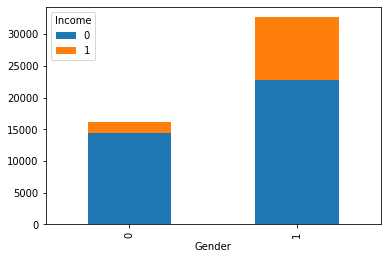

In [7]:
# Plot chart of number of women who're high earners etc.
gender.plot(kind='bar', stacked = True)

In [11]:
Ratio_Males_Females = Ratio_HighIncome_male_female = 0
TotalMales          = len(Adult_df[Adult_df["Gender"]==1])
TotalFemales        = len(Adult_df[Adult_df["Gender"]==0])
Ratio_Males_Females = TotalMales / TotalFemales

MaleHighEarners     = len(Adult_df[(Adult_df["Gender"]==1)  & (Adult_df["Income"]==1)])
FemaleHighEarners   = len(Adult_df[(Adult_df["Gender"]==0)  & (Adult_df["Income"]==1)])
Ratio_HighIncome_male_female = MaleHighEarners / FemaleHighEarners

MaleLowEarners     = len(Adult_df[(Adult_df["Gender"]==1)  & (Adult_df["Income"]==0)])
FemaleLowEarners   = len(Adult_df[(Adult_df["Gender"]==0)  & (Adult_df["Income"]==0)])
Ratio_LowIncome_male_female = MaleLowEarners / FemaleLowEarners


print('Total Males   :', TotalMales)
print('Total Females :', TotalFemales)
print('Percentate of males :',((100*TotalMales) /(TotalMales+TotalFemales)))
print('Ratio Males-Females :', Ratio_Males_Females)
print('')
print('Total of high earning males  :', MaleHighEarners)
print('Total of high earning females:', FemaleHighEarners)
print('Percentate of high earning males :',((100*MaleHighEarners) /(MaleHighEarners+FemaleHighEarners)))
print('Ratio of high erners: male to female ', Ratio_HighIncome_male_female)
print('')
print('Total of low earning males  :', MaleLowEarners)
print('Total of low earning females:', FemaleLowEarners)
print('Percentate of low earning males :',((100*MaleLowEarners) /(MaleLowEarners+FemaleLowEarners)))
print('Ratio of low erners: male to female ', Ratio_LowIncome_male_female)



Total Males   : 32650
Total Females : 16192
Percentate of males : 66.84820441423365
Ratio Males-Females : 2.0164278656126484

Total of high earning males  : 9918
Total of high earning females: 1769
Percentate of high earning males : 84.863523573201
Ratio of high erners: male to female  5.60655737704918

Total of low earning males  : 22732
Total of low earning females: 14423
Percentate of low earning males : 61.1815368052752
Ratio of low erners: male to female  1.576093739166609


In [ ]:
class SelectCols(TransformerMixin):
    """Select columns from a DataFrame."""
    def __init__(self, cols: List[str]) -> None:
        self.cols = cols
    def fit(self, x: None) -> "SelectCols":
        """Nothing to do."""
        return self
    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """Return just selected columns."""
        return x[self.cols]

In [ ]:
class LabelEncoder(TransformerMixin):
    # Convert non-numeric columns to numeric using label encoding. 
    def fit(self, x: pd.DataFrame) -> "LabelEncoder":
        # Generate encoders for each column.
        encoders = {}
        for c in x:
            # Generate encoders using pd.factorize on unique values, then convert to a dictionary
            v, k = zip(pd.factorize(x[c].unique()))
            encoders[c] = dict(zip(k[0], v[0]))
        self.encoders_ = encoders
        return self

    def transform(self, x) -> pd.DataFrame:
        # For columns in x that have learned encoders, apply encoding.
        x = x.copy()
        for c in x:
            # Ignore new, unseen values
            x.loc[~x[c].isin(self.encoders_[c]), c] = np.nan
            # Map learned labels
            x.loc[:, c] = x[c].map(self.encoders_[c])
        # Return without nans
        return x.fillna(-2).astype(int)

In [ ]:
class NumericEncoder(TransformerMixin):
    """Remove invalid values from numerical columns, replace with median."""
    def fit(self, x: pd.DataFrame) -> "NumericEncoder":
        """Learn median for every column in x."""
        # Find median for all columns, handling non-NaNs invalid values and NaNs
        # Where all values are NaNs (after coercion) the median value will be a NaN.
        self.encoders_ = {
            c: pd.to_numeric(x[c], errors='coerce').median(skipna=True) for c in x}
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """For each column in x, encode NaN values are learned 
        median and add a flag column indicating where these 
        replacements were made"""

        # Create a list of new DataFrames, each with 2 columns
        output_dfs = []
        for c in x:
            new_cols = pd.DataFrame()
            # Find invalid values that aren't nans (-inf, inf, string)
            invalid_idx = pd.to_numeric(x[c].replace([-np.inf, np.inf], np.nan),
                                        errors='coerce').isnull()
            # Copy to new df for this column
            new_cols.loc[:, c] = x[c].copy()
            # Replace the invalid values with learned median
            new_cols.loc[invalid_idx, c] = self.encoders_[c]
            # Mark these replacement in a new column called 
            # "[column_name]_invalid_flag"
            # new_cols.loc[:, f"{c}_invalid_flag"] = invalid_idx.astype(np.int8)

            output_dfs.append(new_cols)

        # Concat list of output_dfs to single df
        df = pd.concat(output_dfs,
                       axis=1)

        # Return wtih an remaining NaNs removed. These might exist if the median
        # is a NaN because there was no numeric data in the column at all.
        return df.fillna(0)

In [ ]:
## Constructing the feature engineering pipeline
# LabelEncoding fork: Select object columns -> label encode
pp_object_cols = Pipeline([('select', SelectCols(cols=['Employment', 'Education', 
                                                       'MaritalStatus', 'Occupation', 
                                                       'Relationship','Race','NativeCountry'])),
                           ('process', LabelEncoder())])

# NumericEncoding fork: Select numeric columns -> numeric encode
pp_numeric_cols = Pipeline([('select', SelectCols(cols=['Age','Fnlwgt','EducationNum','CapitalLoss', 
                                                        'CapitalGain','HoursPerWeek', 'Gender','Income'])),
                            ('process', NumericEncoder())])

In [ ]:
# .fit_transform on the adult dataset and write out to new csv file for bias measurement
all_columns = ["Age","Employment","Fnlwgt","Education","EducationalNum","MaritalStatus","Occupation","Relationship",
           "Race","Gender","CapitalGain","CapitalLoss","HoursPerWeek","NativeCountry","Income"]

train_pp = pd.concat((pp_numeric_cols.fit_transform(Adult_df), 
                      pp_object_cols.fit_transform(Adult_df)),
                      axis=1)

In [ ]:
# Convert all label encoded columns from from int64 to float64
train_pp[["Employment","Education", "MaritalStatus","Occupation","Relationship","Race", 
          "NativeCountry"]] = train_pp[["Employment","Education","MaritalStatus","Occupation",
                                        "Relationship","Race",
                                        "NativeCountry"]].astype(float)

In [ ]:
# Reorder the columns to have Income the last column - for aesthetics
columnsTitles = ['Age','Employment','Fnlwgt','Education','EducationNum','MaritalStatus',
                 'Occupation','Relationship','Race','Gender','CapitalGain','CapitalLoss',
                 'HoursPerWeek','NativeCountry', 'Income']
train_pp = train_pp.reindex(columns=columnsTitles)

In [ ]:
train_pp.head(1)

In [ ]:
gender = train_pp.groupby(['Gender', 'Income']).size().unstack(1)
gender

In [ ]:
train_pp.to_csv('./input/adult-cleaned.csv', index=False)

In [ ]:
## NOW DETERMINE THE MOST IMPORTANT FEATURES OF A LOGISTIC REGRESSION & RANDOM FOREST CLASSIFIER

In [ ]:
Adult_df = pd.read_csv('./input/adult-cleaned.csv')

In [ ]:
# The AIF demo drops the following columns - we'll try the same
Adult_df.drop(["Fnlwgt", "NativeCountry", "Relationship", "MaritalStatus"],axis=1,inplace=True)

In [ ]:
# Set up train and test samples.
X = Adult_df.drop("Income",axis=1)
y = Adult_df["Income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [ ]:
# Scale the Test and Train dataframes 
scaler  = MinMaxScaler(copy=False)
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(scaler.fit_transform(X_test.values),  columns=X_test.columns,  index=X_test.index)

In [ ]:
biasedlogmodel = LogisticRegression(random_state=101)
biasedlogmodel.fit(X_train,y_train)
logpredictions = biasedlogmodel.predict(X_test)
print(f"Logistic regression validation accuracy: {biasedlogmodel.score(X_test, y_test)}")

In [ ]:
## CODE TO DISPLAY LOG REGRESSION FEATURE IMPORTANCE 
# List feature importances from the Logistic Regression Classifier
log_feature_importance = pd.DataFrame((biasedlogmodel.coef_[0]),index = X_train.columns,
                         columns=['importance']).sort_values('importance',ascending=False)
log_feature_importance

In [ ]:
## CODE TO DISPLAY LOG FEATURE IMPORTANCE
# Display feature importances from the Logistic Regression Classifier
%matplotlib inline
feature_names = list(Adult_df.columns)

importances = biasedlogmodel.coef_[0]
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
 
# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=20, fontsize = 8)
# Create plot title
plt.title("Biased Logistic Regression Feature Importance")
# Show plot
plt.show()

In [ ]:
biasedrfcmodel = RandomForestClassifier(n_estimators=100,max_depth=4)
biasedrfcmodel.fit(X_train, y_train)
rfcpredictions = biasedrfcmodel.predict(X_test)
print(f"Random forest validation accuracy: {biasedrfcmodel.score(X_test, y_test)}")

In [ ]:
## THIS IS MY CODE TO DISPLAY FEATURE IMPORTANCE
# List feature importances from the Random Forest Classifier
feature_importances = pd.DataFrame(biasedrfcmodel.feature_importances_, index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

In [ ]:
## THIS IS MY CODE TO DISPLAY FEATURE IMPORTANCE
# Display feature importances from the Random Forest Classifier
%matplotlib inline
feature_names = list(Adult_df.columns)

importances = biasedrfcmodel.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
 
# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=20, fontsize = 8)
# Create plot title
plt.title("Biased RFC Feature Importance")
plt.show()

In [ ]:
# Check for the attribute with the most impact on a random forest classification
%matplotlib inline
def feature_importance(mod: Union[LogisticRegression,RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names,'importance': imp,
                         'std': var}).sort_values('importance',ascending=False)
def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_feature_importance(x='feature',y='importance', 
                        data=feature_importance(biasedlogmodel,
                                                names=X_train.columns.tolist(),
                                                scale=X_train.std()),
                       ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - before Mitigating')
plot_feature_importance(x='feature',y='importance', 
                        data=feature_importance(biasedrfcmodel,names=X_train.columns.tolist()),
                       ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - before Mitigating')